## bus proyect 

modules import

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
from math import sin, cos, sqrt, atan2, radians
pd.set_option('precision', 2)
from functools import reduce
import os

Populating the interactive namespace from numpy and matplotlib


constants definition

In [2]:
#range of hours considered
lower_limit_time_range=1200
upper_limit_time_range=1400
line_frequency_bound=10
T = 120

load of data from files

In [3]:
# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
bus_schedules_by_stops = pd.read_csv('files/uptu_pasada_variante.csv',sep=';')

# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
uptu_pasada_circular = pd.read_csv('files/uptu_pasada_circular.csv',sep=';')

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
stops_ubication = gpd.read_file('files/v_uptu_paradas.shx')
stops_ubication = pd.DataFrame(stops_ubication)

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
recorridos_omnibus = gpd.read_file('files/v_uptu_lsv.dbf')
recorridos_omnibus = pd.DataFrame(recorridos_omnibus)

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
ubicacion_puntos_control = gpd.read_file('files/v_uptu_controles.dbf')
ubicacion_puntos_control = pd.DataFrame(ubicacion_puntos_control)

# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
origen_destino_lineas = gpd.read_file('files/v_uptu_lsv_destinos.dbf')
origen_destino_lineas = pd.DataFrame(origen_destino_lineas)

# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
recorridos_variantes_no_maximales = gpd.read_file('files/uptu_variante_no_maximal.dbf')
recorridos_variantes_no_maximales = pd.DataFrame(recorridos_variantes_no_maximales)




demand for defined period

In [4]:
# TODO: pedir a Renzo el calculo de esto

file_name='files/trasbordos.csv'
transfers = pd.read_csv(file_name,sep=',')
transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
transfers_all_day = transfers

file_name='files/trasbordos_' + str(lower_limit_time_range) + '_' + str(upper_limit_time_range) +'.csv'
transfers = pd.read_csv(file_name,sep=',')
transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
transfers_1200_1400 = transfers


display(transfers_all_day.head())
display(transfers_1200_1400.head(50))





,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers
0,2427,2426,1096,2579,309
1,1885,4468,1759,1667,204
2,1108,4775,1122,650,186
3,1942,4399,1759,987,165
4,4212,5709,170,2579,149


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers
0,1942.0,4848,1759,2422,31
1,4212.0,5709,170,1290,30
2,2392.0,2295,2050,1418,30
3,4135.0,4135,1117,170,28
4,4212.0,5709,2411,1290,25
5,4815.0,4815,1749,647,25
6,2427.0,2426,1096,1290,25
7,4925.0,4925,667,2073,25
8,1599.0,5709,1438,2579,24
9,2392.0,2295,2050,540,23


### start  proccesing

output file structure

4 3 120 //lines sync_points period

1 2 2 100 3 10 15 16 0 // line1 line2 dist demand wb Wb TTl1 TTl2 bach

2 3 1  50 5  8 18 22 0

3 4 1  75 5  8 18 22 0

5 15

4 12

4 10

4 10


lines with low frecuency

In [5]:
valid_lines_list = bus_schedules_by_stops.query('ordinal==1').copy()
valid_lines_list['count'] = 1
valid_lines_list = valid_lines_list.groupby('cod_variante').sum().reset_index()
valid_lines_list=valid_lines_list[valid_lines_list['count'] > line_frequency_bound]['cod_variante']


filtering lines with low frecuency in bus stops

In [6]:
bus_schedules_by_stops = bus_schedules_by_stops[bus_schedules_by_stops['cod_variante']
                                                .isin(valid_lines_list)] 


merge transfers with no maximal lines

In [7]:
#display(recorridos_variantes_no_maximales.head())

def complete_maximals(transfers):
    transfers_with_no_max = transfers.copy()
    transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                     how='left', left_on=['line_id_1'], right_on=['COD_VARIAN'])
    transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'COD_VAR_01',]]
    transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'line_id_1_var_01',]

    transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                     how='left', left_on=['line_id_2'], right_on=['COD_VARIAN'])

    transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers','line_id_1_var_01',
                                                  'COD_VAR_01',]]
    transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'line_id_1_var_01','line_id_2_var_01',]

    transfers_with_no_max['line_id_1_var_01'] =\
                transfers_with_no_max.apply(lambda e: e.line_id_1 
                                            if math.isnan(e.line_id_1_var_01)
                                            else e.line_id_1_var_01,axis = 1) 

    transfers_with_no_max['line_id_2_var_01'] =\
                transfers_with_no_max.apply(lambda e: e.line_id_2 
                                            if math.isnan(e.line_id_2_var_01) 
                                            else e.line_id_2_var_01,axis = 1)
    return transfers_with_no_max

#display(transfers_all_day.head(1))
#display(transfers_1200_1400_with_max.head(1))

transfers_all_day_with_max = complete_maximals(transfers_all_day)
transfers_1200_1400_with_max = complete_maximals(transfers_1200_1400)


display(transfers_all_day_with_max.head(1))
display(transfers_1200_1400_with_max.head(1))



,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,2427,2426,1096,2579,309,1096.0,1311.0


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,1942.0,4848,1759,2422,31,1759.0,1736.0


filtering valid transfers, according to its lines frequency

In [8]:
def filter_transfers(transfers_with_max):
    transfers_with_max = transfers_with_max[transfers_with_max['line_id_1'].isin(valid_lines_list)] 
    transfers_with_max = transfers_with_max[transfers_with_max['line_id_2'].isin(valid_lines_list)]
    return transfers_with_max

transfers_all_day_with_max = filter_transfers(transfers_all_day_with_max)
transfers_1200_1400_with_max = filter_transfers(transfers_1200_1400_with_max)

display(transfers_all_day_with_max.head(1))
display(transfers_1200_1400_with_max.head(1))

,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,2427,2426,1096,2579,309,1096.0,1311.0


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,1942.0,4848,1759,2422,31,1759.0,1736.0


calculate tt

In [9]:
#time1-time2
def diff(time1,time2):
    hours1 = time1 // 100
    minutes1 = time1 % 100
    hours2 = time2 // 100
    minutes2 = time2 % 100
    minutos_desde_la_cero_hora1=hours1*60+minutes1
    minutos_desde_la_cero_hora2=hours2*60+minutes2
    return minutos_desde_la_cero_hora2 - minutos_desde_la_cero_hora1

def ttaux(frecuencia,bus_in):
    bus=bus_in.copy()
    bus=bus[bus.ordinal == 1]
    bus=bus[bus['frecuencia'] ==  frecuencia]
    bus=bus[bus['tipo_dia'] ==  1]
    bus=bus[bus['dia_anterior'] ==  'N']
    #bus=bus
    #display(bus)
    #display(bus)
    return bus['hora'].iloc[0].copy()


def tt(linea,parada,bus_schedules_by_stops):

    #linea=170
    #parada=4212
    #display(linea)
    #display(parada)
    query='cod_variante=='+ str(linea)# +' and cod_ubic_parada == '+str(parada)
    bus_schedules_by_stops_aux = bus_schedules_by_stops.query(query).copy()
    aux1=bus_schedules_by_stops_aux.copy()
    
    query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)
    aux2 = bus_schedules_by_stops.query(query).copy()
    
    #display(aux2)
    
    aux2 = aux2.query('tipo_dia == 1').copy()
       
    frecuencias_validas_horarios= aux1.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                             str(lower_limit_time_range-400) +
                                            'and hora <= ' + str(upper_limit_time_range+400)
                                            )
    
    aux1 = aux1[aux1['frecuencia'].isin(frecuencias_validas_horarios['frecuencia'])]
    aux2 = aux2[aux2['frecuencia'].isin(frecuencias_validas_horarios['frecuencia'])]
    #aux2 = aux2.query('frecuencia == 7070')
    
    if (aux2.size>0):
        
        #display(aux2)
        aux2['hora_salida'] =\
        aux2.apply(lambda e: ttaux(e.frecuencia,aux1),axis = 1) 

        #display(aux2)
        aux2['TT'] =\
            aux2.apply(lambda e: diff(e.hora_salida,e.hora),axis = 1) 
        aux2 =\
        aux2.groupby(['tipo_dia','cod_variante','cod_ubic_parada']).mean().reset_index()


        #display(aux2)
        query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)#+' and tipo_dia == 1 '
        
        aaa= aux2.query(query)['TT']
        
#        print(aaa)
        return aaa
    else:
        return -1

def add_tt1_tt2(transfers_with_no_max):        
    transfers_with_no_max2 = transfers_with_no_max#[transfers_with_no_max['line_id_1'] ==  170].copy()
    transfers_with_no_max2['TT1'] =\
            transfers_with_no_max2.apply(lambda e: tt(e.line_id_1_var_01,e.stop_id_1,bus_schedules_by_stops),axis = 1).copy() 
    transfers_with_no_max2['TT2'] =\
            transfers_with_no_max2.apply(lambda e: tt(e.line_id_2_var_01,e.stop_id_2,bus_schedules_by_stops),axis = 1).copy() 
    transfers_with_no_max2 = transfers_with_no_max2.query('TT1 >= 0 and TT2 >= 0')
    return transfers_with_no_max2

transfers_all_day_max_tts = add_tt1_tt2(transfers_all_day_with_max)
transfers_1200_1400_max_tts = add_tt1_tt2(transfers_1200_1400_with_max)

display(transfers_all_day_max_tts.head(50))
display(transfers_1200_1400_max_tts.head(50))
    
    
    

/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01,TT1,TT2
0,2427,2426,1096,2579,309,1096.0,1311.0,23.12,21.78
1,1885,4468,1759,1667,204,1759.0,1667.0,18.33,0.00
2,1108,4775,1122,650,186,1122.0,650.0,20.62,15.35
3,1942,4399,1759,987,165,1759.0,982.0,26.33,12.00
4,4212,5709,170,2579,149,170.0,1311.0,21.75,12.00
5,2447,2437,1276,1092,148,1274.0,1092.0,50.50,37.75
7,2427,2426,1096,1290,136,1096.0,1282.0,23.12,23.80
9,4843,4930,1122,1347,128,1122.0,1347.0,22.62,17.13


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01,TT1,TT2
1,4212.0,5709,170,1290,30,170.0,1282.0,21.75,[12.0]
2,2392.0,2295,2050,1418,30,2050.0,1418.0,8.13,[2.0]
3,4135.0,4135,1117,170,28,1117.0,170.0,84.56,[0.0]
4,4212.0,5709,2411,1290,25,708.0,1282.0,50.67,[12.0]
6,2427.0,2426,1096,1290,25,1096.0,1282.0,23.12,[23.8]
9,2392.0,2295,2050,540,23,2050.0,522.0,8.13,[25.0833333333]
10,2447.0,2437,1276,1092,23,1274.0,1092.0,50.50,[37.746031746]
11,4925.0,4930,1580,1347,23,1580.0,1347.0,10.00,[17.1343283582]
12,1108.0,4775,1122,650,22,1122.0,650.0,20.62,[15.3521126761]
13,1858.0,1858,969,1758,21,968.0,1758.0,67.18,[0.0]


merge transfers and stops ubication to get stops geometriy (coordinates)

In [10]:
def add_sptop_coors(transfers_with_no_max):    
    transfers_with_stop_coors = transfers_with_no_max.copy()
    transfers_with_stop_coors =  pd.merge(transfers_with_stop_coors, stops_ubication, 
                     how='left', left_on=['stop_id_1','line_id_1_var_01'], right_on=['COD_UBIC_P',
                                                                                     'COD_VARIAN'])
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                           'stop_id_2','line_id_1_var_01',
                                                             'line_id_2_var_01','n_transfers','geometry','TT1','TT2']]
    transfers_with_stop_coors.columns = ['line_id_1','line_id_2','stop_id_1','stop_id_2',
                                         'line_id_1_var_01','line_id_2_var_01','n_transfers',
                                          'line_1_geometry','TT1','TT2']
    transfers_with_stop_coors = pd.merge(transfers_with_stop_coors, stops_ubication, 
                     how='left', left_on=['stop_id_2','line_id_2_var_01'], right_on=['COD_UBIC_P',
                                                                                     'COD_VARIAN'])
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                           'stop_id_2','line_id_1_var_01',
                                                             'line_id_2_var_01','n_transfers',
                                                           'line_1_geometry','geometry','TT1','TT2']]
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1',
                                                             'line_id_2','n_transfers',
                                                             'line_1_geometry',
                                                             'geometry','TT1','TT2']]
    transfers_with_stop_coors.columns = ['line_id_1',
                                        'line_id_2','n_transfers','line_1_geometry',
                                        'line_2_geometry','TT1','TT2']
    return transfers_with_stop_coors

transfers_all_day_max_tts_coors = add_sptop_coors(transfers_all_day_max_tts)
transfers_1200_1400_max_tts_coors = add_sptop_coors(transfers_1200_1400_max_tts)

display(transfers_all_day_max_tts_coors.head(1))
display(transfers_1200_1400_max_tts_coors.head(1))



,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,21.78


,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2
0,170,1290,30,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,[12.0]


caculate distance between stops of lines

In [11]:
def dist(geometry_1,geometry_2):
    return geometry_1.distance(geometry_2)

def add_dist(transfers_with_stop_coors):
    transfers_with_stop_coors['dist'] =\
    transfers_with_stop_coors.apply(lambda e:dist(e.line_1_geometry,e.line_2_geometry),axis = 1) 
    transfers_with_stop_coors.head(20)
    return transfers_with_stop_coors
    
transfers_all_day_max_tts_coors_dist = add_dist(transfers_all_day_max_tts_coors)
transfers_1200_1400_max_tts_coors_dist = add_dist(transfers_1200_1400_max_tts_coors)

display(transfers_all_day_max_tts_coors_dist.head(1))
display(transfers_1200_1400_max_tts_coors_dist.head(1))

,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2,dist
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,21.78,69.71


,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2,dist
0,170,1290,30,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,[12.0],107.06


intersection points

In [12]:
def dist(transfers_with_stop_coors):
    points = transfers_with_stop_coors[['line_id_1','line_id_2','dist','n_transfers','TT1','TT2']]
    points.columns = ['line_i','line_j','dist','demand','TT_i','TT_j']
    points.insert(4, 'wb',5)
    points.insert(5, 'wB', 10)
    #points.insert(6, 'TT_i', np.zeros(len(points)))
    #points.insert(7, 'TT_j', np.zeros(len(points)))
    points.insert(8, 'BP', np.zeros(len(points)))
    return points

points_all_day = dist(transfers_all_day_max_tts_coors_dist)
points_1200_1400 = dist(transfers_1200_1400_max_tts_coors_dist)

display(points_all_day.head(1))
display(points_1200_1400.head(1))


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1096,2579,69.71,309,5,10,23.12,21.78,0.0


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,170,1290,107.06,30,5,10,21.75,[12.0],0.0


frequency

In [13]:
def max_min_avg_line_frec( linea ,bus_schedules_by_stops,lower_limit_time_range,upper_limit_time_range):
    resultado=bus_schedules_by_stops.query('tipo_dia==1 and ordinal==1 and dia_anterior== "N" and cod_variante=='
                                           +str(linea)+
                                           ' and hora>='+str(lower_limit_time_range-400)+' and hora<='
                                           +str(upper_limit_time_range+400))
    resultadoHoraTolistSinRepetidos=list(set(resultado.hora.tolist()))
    resultadoHoraTolistSinRepetidos = sorted(resultadoHoraTolistSinRepetidos)
    cant_rows = len(resultadoHoraTolistSinRepetidos)
    
    maxima_fecuencia = 0
    minima_frecuencia = 10000000
    lista_frecuencias_minutos_linea=[]
    
    for i in range(cant_rows-1):
        time1=resultadoHoraTolistSinRepetidos[i]
        time2=resultadoHoraTolistSinRepetidos[i+1]
        hours1 = time1 // 100
        minutes1 = time1 % 100
        hours2 = time2 // 100
        minutes2 = time2 % 100
        minutos_desde_la_cero_hora1=hours1*60+minutes1
        minutos_desde_la_cero_hora2=hours2*60+minutes2
        resta = minutos_desde_la_cero_hora2-minutos_desde_la_cero_hora1
        lista_frecuencias_minutos_linea.append(resta)
        if(maxima_fecuencia<resta):
            maxima_fecuencia=resta
    #elimina los duplicados    
    lista_frecuencias_minutos_linea = list(set(lista_frecuencias_minutos_linea)) 
    retornero =	{
      "min": min(lista_frecuencias_minutos_linea),
      "max": maxima_fecuencia,
      "avg": sum(lista_frecuencias_minutos_linea)/len(lista_frecuencias_minutos_linea)
    }
    return retornero

def frequencies(points):

    lista_min = []
    lista_max = []
    lista_avg = []
    lineas_en_orden_procesado=[]



    # list of used stops
    aux_lines_i =  pd.DataFrame({'linea': points['line_i'] })
    aux_lines_j =  pd.DataFrame({'linea': points['line_j'] })
    aux_lines = aux_lines_i.append(aux_lines_j)
    aux_lines = aux_lines.drop_duplicates(subset=None, keep='first', inplace=False)
    frequency = aux_lines.copy()

    #display(lista_linea)

    for i in range(len(frequency)):
       lista_linea=frequency.linea.tolist()
       min_max_promedio= max_min_avg_line_frec(lista_linea[i],bus_schedules_by_stops,
                                               lower_limit_time_range,upper_limit_time_range)
       lista_min.append(min_max_promedio["min"])
       lista_max.append(min_max_promedio["max"])
       lista_avg.append(min_max_promedio["avg"])
       lineas_en_orden_procesado.append(lista_linea[i])

    lineas_min_max_avg=pd.DataFrame({'linea': lineas_en_orden_procesado, 'h': lista_min, 'H': lista_max, 'avg': lista_avg})

    frec_h_H_avg =  pd.merge(frequency, lineas_min_max_avg, 
                     how='left', left_on=['linea'], right_on=['linea'])
    return frec_h_H_avg

frequencies_all_day = frequencies(points_all_day)
frequencies_1200_1400 = frequencies(points_1200_1400)

display(frequencies_all_day.head(20))
display(frequencies_1200_1400.head(2))

,linea,h,H,avg
0,1096,5,24,12.79
1,1759,15,29,21.64
2,1122,7,18,11.70
3,170,7,12,9.50
4,1276,2,12,6.90
5,2579,3,13,7.90
6,1667,8,20,11.60
7,650,6,16,10.67
8,987,7,28,15.71
9,1092,6,23,13.47


,linea,h,H,avg
0,170,7,12,9.5
1,2050,8,12,10.0


calculate W w

In [14]:
def add_ws(points,frecs):

    points_merge_frec_h_H_avg_i= pd.merge(points, frecs, 
                               how='left', left_on=['line_i'], right_on=['linea'])

    points_merge_frec_h_H_avg_j= pd.merge(points, frecs, 
                               how='left', left_on=['line_j'], right_on=['linea'])

    #muestro tabla de frequencys para parejas de lineas
    frecueni_j=pd.DataFrame({'line_i': points.line_i.tolist(),
                         'line_j': points.line_j.tolist(),
                         'h_i': points_merge_frec_h_H_avg_i.h.tolist(),
                         'Hi': points_merge_frec_h_H_avg_i.H.tolist(),
                         'h_j': points_merge_frec_h_H_avg_j.h.tolist(),
                         'Hj': points_merge_frec_h_H_avg_j.H.tolist(),
                         'avg_i': points_merge_frec_h_H_avg_i.avg.tolist(),
                         'avg_j': points_merge_frec_h_H_avg_j.avg.tolist()

                          }) 


    #display(frecueni_j)

    #wb es el minimo de los h de las dos lineas del punto
    minimasFrecs=[]
    for i in range(len(frecueni_j)):
        minimasFrecs.append(min(points_merge_frec_h_H_avg_i.h.tolist()[i],points_merge_frec_h_H_avg_j.h.tolist()[i]))

    #display(frec_h_H_avg.H.tolist())
    #display(points_merge_frec_h_H_avg)
    #wB se setea por el H de la frequency 
    points=pd.DataFrame({'line_i': points.line_i.tolist(),
                         'line_j': points.line_j.tolist(),
                         'dist': points.dist.tolist(),
                         'demand': points.demand.tolist(),
                         'wb': minimasFrecs,
                         'wB': points_merge_frec_h_H_avg_j.H.tolist(),
                         'TT_i': points.TT_i.tolist(),
                         'TT_j': points.TT_j.tolist(),
                         'BP': points.BP.tolist(),
                          })  
    return points
    
points_all_day = add_ws(points_all_day,frequencies_all_day)
points_1200_1400 = add_ws(points_1200_1400,frequencies_1200_1400)

display(points_all_day.head(2))
display(points_1200_1400.head(2))
        

,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1096,2579,69.71,309,3,13,23.12,21.78,0.0
1,1759,1667,202.95,204,8,20,18.33,0.00,0.0


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,170,1290,107.06,30,4,12,21.75,[12.0],0.0
1,2050,1418,31.01,30,4,30,8.13,[2.0],0.0


filtering lines that arrive out of period

In [15]:
def filter_out_of_period(points,frecs):
    frecs = frecs[frecs['avg'] < 60]
    frecs = frecs[frecs['H'] < 120]
    points = points[ points['line_i'].isin(frecs['linea']) 
                    & 
                    points['line_j'].isin(frecs['linea']) 
                    ]
    
    return points,frecs
    
    
points_1200_1400,frequencies_1200_1400 = filter_out_of_period(points_1200_1400,frequencies_1200_1400)
points_all_day,frequencies_all_day = filter_out_of_period(points_all_day,frequencies_all_day)

#display(points_1200_1400.head())
#display(frequencies_1200_1400.head())
#display(points_all_day.head(100))
#display(points_1200_1400.head(100))


int(ceil) to distance and time travel


In [16]:
def to_int_ceil(points):
    points['dist'] = points.apply(lambda e:math.ceil(e.dist),axis = 1)
    points['TT_i'] = points.apply(lambda e:math.ceil(e.TT_i),axis = 1) 
    points['TT_j'] = points.apply(lambda e:math.ceil(e.TT_j),axis = 1) 
    points['BP'] = points.apply(lambda e:math.ceil(e.BP),axis = 1) 
    return points

    
points_1200_1400 = to_int_ceil(points_1200_1400)
points_all_day = to_int_ceil(points_all_day)


generate sub sets

## generate scenarios

In [125]:
#12 14

# GRUPO A
# scenario_0 BS.12-14.22.14.120.100.0
# scenario_1 BS.12-14..24.15.120.100.0
# scenario_2 BS.12-14..25.17.120.100.0

# GRUPO B
# scenario_3 BS.12-14.35.33.120.100.0
# scenario_4 BS.12-14.35.33.120.75.0
# scenario_5 BS.12-14.35.33.120.50.0

# GRUPO C
# scenario_6 BS.12-14.34.31.120.100.0
# scenario_7 BS.12-14.34.31.120.75.0
# scenario_8 BS.12-14.34.31.120.50.0

# GRUPO D
# scenario_9 BS.12-14.33.30.120.100.0
# scenario_10 BS.12-14.33.30.120.75.0
# scenario_11 BS.12-14.33.30.120.50.0

#7 9

#19 21

scenario_array = [None] * 9



### GRUPO A

In [126]:
points_1200_1400_a = points_1200_1400[0:14].copy()
points_1200_1400_b = points_1200_1400[0+3:15+3].copy()
points_1200_1400_c = points_1200_1400[34-18:34].copy()

frequencies_1200_1400_a = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_1200_1400_a['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_1200_1400_a['line_j'] )]

frequencies_1200_1400_b = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_1200_1400_b['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_1200_1400_b['line_j'] )]

frequencies_1200_1400_c = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_1200_1400_c['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_1200_1400_c['line_j'] )]


# GRUPO A
#scenario_array.append({})
scenario_array[0] = {'name':"BS.12-14.22.14.120.100.0",'name2':'scenario_0',
                     'ps':points_1200_1400_a,'fs':frequencies_1200_1400_a}
#scenario_array.append({})
scenario_array[1] = {'name':"BS.12-14..24.15.120.100.0",'name2':'scenario_1',
                     'ps':points_1200_1400_b,'fs':frequencies_1200_1400_b}
#scenario_array.append({})
scenario_array[2] = {'name':"BS.12-14..25.17.120.100.0",'name2':'scenario_2',
                     'ps':points_1200_1400_c,'fs':frequencies_1200_1400_c}



### GRUPO B

In [127]:
# GRUPO B
points_1200_1400_d = points_1200_1400.copy()
points_1200_1400_e = points_1200_1400.copy()
points_1200_1400_f = points_1200_1400.copy()

points_1200_1400_d['wB'] = points_1200_1400['wB']
points_1200_1400_e['wB'] = points_1200_1400['wB'] * 0.9
points_1200_1400_f['wB'] = points_1200_1400['wB']* 0.75

points_1200_1400_d['wB'] = points_1200_1400_d.apply(lambda e:math.ceil(e.wB),axis = 1)
points_1200_1400_e['wB'] = points_1200_1400_e.apply(lambda e:math.ceil(e.wB),axis = 1)
points_1200_1400_f['wB'] = points_1200_1400_f.apply(lambda e:math.ceil(e.wB),axis = 1)

frequencies_1200_1400_d = frequencies_1200_1400
frequencies_1200_1400_e = frequencies_1200_1400
frequencies_1200_1400_f = frequencies_1200_1400

# GRUPO B
#scenario_array.append({})
scenario_array[3] = {'name':"BS.12-14.35.33.120.100.0",'name2':'scenario_3',
                     'ps':points_1200_1400_d,'fs':frequencies_1200_1400_d}
#scenario_array.append({})
scenario_array[4] = {'name':"BS.12-14.35.33.120.90.0",'name2':'scenario_4',
                     'ps':points_1200_1400_e,'fs':frequencies_1200_1400_e}
#scenario_array.append({})
scenario_array[5] = {'name':"BS.12-14.35.33.120.75.0",'name2':'scenario_5',
                     'ps':points_1200_1400_f,'fs':frequencies_1200_1400_f}

#display(scenario_array[5]['points'])
display(scenario_array[5]['ps'].shape[0])
display(scenario_array[5]['fs'].shape[0])
#points_1200_1400

33

35

### GRUPO C


In [128]:
_points_aux1 = points_1200_1400[0+7:31+7].copy()
_points_aux2 = points_1200_1400[0+7:31+7].copy()
_points_aux3 = points_1200_1400[0+7:31+7].copy()

points_aux1['wB'] = _points_aux1['wB']
points_aux2['wB'] = _points_aux2['wB'] * 0.9
points_aux3['wB'] = _points_aux3['wB']* 0.75

points_aux1['wB'] = points_aux1.apply(lambda e:math.ceil(e.wB),axis = 1)
points_aux2['wB'] = points_aux2.apply(lambda e:math.ceil(e.wB),axis = 1)
points_aux3['wB'] = points_aux3.apply(lambda e:math.ceil(e.wB),axis = 1)


frequencies_aux1 = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_aux1['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_aux1['line_j'] )]

frequencies_aux2 = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_aux1['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_aux2['line_j'] )]

frequencies_aux3 = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_aux1['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_aux3['line_j'] )]


# GRUPO C
#scenario_array.append({})
scenario_array[6]= {'name':"BS.12-14.33.26.120.100.0",'name2':'scenario_6',
                     'ps':points_aux1,'fs':frequencies_aux1}
#scenario_array.append({})
scenario_array[7]= {'name':"BS.12-14.33.26.120.90.0",'name2':'scenario_7',
                     'ps':points_aux2,'fs':frequencies_aux2}
#scenario_array.append({})
scenario_array[8]= {'name':"BS.12-14.33.26.120.75.0",'name2':'scenario_8',
                     'ps':points_aux3,'fs':frequencies_aux3}


#display(scenario_array[6]['points'])
#display(scenario_array[8]['points'].shape[0])
#display(scenario_array[8]['freqs'].shape[0])

mapping

In [129]:
def mapping(points,frec_h_H_avg):

    #recorrer frec_h_H_avg y agregar columna
    #luego agregar nuevas columnas a points

    mapeo_linea_id=[]
    #se construye mapeo
    rango_lineas_procesadas= range(0,len(frec_h_H_avg))
    lista_lineas=frec_h_H_avg.linea.tolist()  
    mapeo_linea_id=pd.DataFrame({'linea': lista_lineas, 'id': rango_lineas_procesadas})    

    frec_h_H_avg_map =  pd.merge(frec_h_H_avg, mapeo_linea_id, 
                     how='left', left_on=['linea'], right_on=['linea'])




    #crear nuevo dataframe con el mismo nombre de clumna del join ahorra que agregue columnas que no se usan
    mapeo_linea_id_i=pd.DataFrame({'line_i': lista_lineas, 'id_i': rango_lineas_procesadas})    


    points_map_i =  pd.merge(points, mapeo_linea_id_i, 
                     how='inner', left_on=['line_i'], right_on=['line_i'])


    #crear nuevo dataframe con el mismo nombre de clumna del join ahorra que agregue columnas que no se usan
    mapeo_linea_id_j=pd.DataFrame({'line_j': lista_lineas, 'id_j': rango_lineas_procesadas})    

    points_map_i_j =  pd.merge(points_map_i, mapeo_linea_id_j, 
                     how='inner', left_on=['line_j'], right_on=['line_j'])



    #display(frec_h_H_avg_map)

    #display(points_map_i_j)

    #construye nuevo dataframe con las columnas en otro orden

    points_con_ids=pd.DataFrame({'line_i': points_map_i_j.id_i.tolist(),
                                 'line_j': points_map_i_j.id_j.tolist(),
                                 'dist': points_map_i_j.dist.tolist(),
                                 'demand': points_map_i_j.demand.tolist(),
                                 'wb': points_map_i_j.wb.tolist(),
                                 'wB': points_map_i_j.wB.tolist(),
                                 'TT_i': points_map_i_j.TT_i.tolist(),
                                 'TT_j': points_map_i_j.TT_j.tolist(),
                                 'BP': points_map_i_j.BP.tolist(),
                                  })  

    frec_h_H_avg_ids=pd.DataFrame({'linea': frec_h_H_avg_map.id.tolist(),
                                   'h': frec_h_H_avg_map.h.tolist(),
                                   'H': frec_h_H_avg_map.H.tolist(),
                                   'avg': frec_h_H_avg_map.avg.tolist()
                                  })  
    return points_con_ids, frec_h_H_avg_ids





#points_all_day_mapped, frequencies_all_day_mapped = mapping(points_all_day,frequencies_all_day)
#points_1200_1400_mapped, frequencies_1200_1400_mapped = mapping(points_1200_1400,frequencies_1200_1400)

for i in range(len(scenario_array)):
    ps_m, fs_m = mapping(scenario_array[i]['ps'],scenario_array[i]['fs'])
    scenario_array[i]['ps_m'] = ps_m
    scenario_array[i]['fs_m'] = fs_m
#scenario_array[i]['fs_m']

current system solution

In [130]:
def current_sulution_by_im(frequency):

    current_solution_aux = bus_schedules_by_stops.copy()
    frecuencias_validas_horarios= current_solution_aux.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                                 str(lower_limit_time_range-400) +
                                                'and hora <= ' + str(upper_limit_time_range+400)
                                                ).copy()
    current_solution_aux = current_solution_aux[current_solution_aux['frecuencia'].isin(
        frecuencias_validas_horarios['frecuencia'])].copy()
    
    current_solution_aux = current_solution_aux.query('ordinal == 1 and tipo_dia==1').copy()
    current_solution_aux['siguiente'] = current_solution_aux.hora.shift(-1)
    current_solution_aux['diff'] = current_solution_aux.apply(lambda e:diff(
        e.hora,e.siguiente),axis = 1) .copy()

    current_solution_aux = current_solution_aux[current_solution_aux['cod_variante']
                                                .isin(frequency['linea'])].copy()
    current_solution_aux = current_solution_aux[current_solution_aux['diff'] > 0].copy()
    current_solution_aux = current_solution_aux.groupby('cod_variante').mean().reset_index()
    frec_h_H_avg_aux =  pd.merge(frequency, current_solution_aux, 
                     how='left', left_on=['linea'], right_on=['cod_variante']).copy()

    frec_h_H_avg_aux = frec_h_H_avg_aux[['diff']]
    frec_h_H_avg_aux=frec_h_H_avg_aux.round(0)
    current_solution_aux = frec_h_H_avg_aux
    current_solution_aux_imm = current_solution_aux
    return current_solution_aux_imm


#current_sulution_by_im_all_day = current_sulution_by_im(frequencies_all_day)
#current_sulution_by_im_1200_1400 = current_sulution_by_im(frequencies_1200_1400)

#urrent_sulution_by_im_all_day = to_int_ceil_sol(current_sulution_by_im_all_day)
#current_sulution_by_im_1200_1400 = to_int_ceil_sol(current_sulution_by_im_1200_1400)



def to_int_ceil_sol(sol):
    #display(sol)
    sol['diff'] = sol.apply(lambda e: math.ceil(e),axis = 1)
    return  to_int_ceil_sol(sol)

for i in range(len(scenario_array)):
    c_s = current_sulution_by_im(scenario_array[i]['fs'])
    scenario_array[i]['c_s'] = c_s
# scenario_array[5]['c_s']

file wrinting

In [131]:
def file_writing(points,frequency,current_solution, file_name):
   

    #dfList = current_solution['diff'].tolist()
    #display(dfList)
    
    d = {
     'cantidad_de_lineas': [frequency.shape[0]],
     'puntos_sincro': [points.shape[0]],
     'periodo': [T],      
    }
    head = pd.DataFrame(data=d)
    
    head.to_csv(file_name + '_h', sep=' ', encoding='utf-8', index=False, header=False)
    frequency[['h','H']].to_csv(file_name + '_f', sep=' ', encoding='utf-8', index=False, header=False)
    points.to_csv(file_name + '_p', sep=' ', encoding='utf-8', index=False, header=False)
    current_solution.to_csv(file_name + '_s', sep=' ', encoding='utf-8', index=False, header=False)

    filenames = [file_name + '_h',file_name + '_p',file_name + '_f',file_name + '_s',]
    with open(file_name, 'w') as outfile:
        for fname in filenames:
            with open(fname) as infile:
                for line in infile:
                    outfile.write(line)
    #import os
    os.remove(file_name + '_h')
    os.remove(file_name + '_p')
    os.remove(file_name + '_f')
    os.remove(file_name + '_s')
    
    
for i in range(len(scenario_array)):
    s = scenario_array[i]
    file_writing(s['ps_m'],s['fs_m'],s['c_s'], s['name'])
      


current system solution to file (deprecated)

In [24]:
#def file_writing_current_solution_by_im(current_sulution, file_name):
#    current_sulution.to_csv(file_name, 
#                                      sep=' ', encoding='utf-8', index=False, header=False)

    
#def sol_to_int_ceil(sol):
#    sol['diff'] = sol.apply(lambda e: math.ceil(e),axis = 1)
#    return sol    

#display(sol_to_int_ceil(current_sulution_by_im_all_day).head())

#file_writing_current_solution_by_im(sol_to_int_ceil(current_sulution_by_im_all_day),'real_timetable_all_day')
#file_writing_current_solution_by_im(sol_to_int_ceil(current_sulution_by_im_1200_1400),'real_timetable_1200_1400')


fitness current system

In [25]:
#display(frec_h_H_avg_ids_to_file)
#display(points_con_ids)
#display(current_solution_aux)

fitness

In [132]:
def fitness1(current_solution_aux,points_con_ids):
    SPEED = 6
    suma = 0
    for i in range(points_con_ids.shape[0]): # For each synchronization point
        line_i = points_con_ids.line_i[i]
        line_j = points_con_ids.line_j[i]

        TT_i = points_con_ids.TT_i[i]
        TT_j = points_con_ids.TT_j[i]
        t_dist = (points_con_ids.dist[i]/1000/SPEED*60);

        t_dist = math.ceil(t_dist)

        demand = points_con_ids.demand[i]

        w_b = points_con_ids.wb[i]
        W_b = points_con_ids.wB[i]

        if ( ( ( (current_solution_aux['diff'][line_j]+TT_j) - 
                (current_solution_aux['diff'][line_i]+TT_i)) >= t_dist )
        and ( ( (current_solution_aux['diff'][line_j]+TT_j) -
                 (current_solution_aux['diff'][line_i]+TT_i)) <= W_b + t_dist) ):
            suma = suma + demand;
    return suma

fitness_current_sulution_by_im_all_day= fitness1(current_sulution_by_im_all_day,points_all_day_mapped)
fitness_current_sulution_by_im_1200_1400 = fitness1(current_sulution_by_im_1200_1400,points_1200_1400_mapped)

display(fitness_current_sulution_by_im_all_day)
display(fitness_current_sulution_by_im_1200_1400)
    

0

88

improved fitness


In [133]:
def fitness2_deprecated(current_solution_aux,points_con_ids):

    #current_solution_aux = current_solution_aux_imm # fitness 28924

    #lista = '19 21 10 11 10 10 15 10 20 15 4 10'
    #lista = lista.split(' ')
    #lista = list(map(lambda x: int(x), lista))
    #current_solution_aux = pd.DataFrame(data={'diff': lista}) #  fitness 24669
    #display(current_solution_aux)

    sync_linea_i = []
    sync_linea_j = []
    sync_trip_i = []
    sync_trip_j = []

    SPEED = 6
    suma = 0
    T = 120 # minumtos
    suma_espera = 0


    for k in range(points_con_ids.shape[0]): # For each synchronization point
        line_i = points_con_ids.line_i[k]
        line_j = points_con_ids.line_j[k]
        #print(line_j)

        TT_i = points_con_ids.TT_i[k]
        TT_j = points_con_ids.TT_j[k]
        t_dist = (points_con_ids.dist[k]/1000/SPEED*60);

        t_dist = math.ceil(t_dist)

        demand = points_con_ids.demand[k]
        #print(demand)
        w_b = points_con_ids.wb[k]
        W_b = points_con_ids.wB[k]

        x= current_solution_aux['diff'][int(line_i)]
        y= current_solution_aux['diff'][int(line_j)]
        trips_i = list(range(int(x),T+1,int(x)))
        trips_j = list(range(int(y),T+1,int(y)))

        TT_i = math.floor(TT_i) 
        TT_j = math.floor(TT_j) 

        for i in range(len(trips_i)):
            for j in range(len(trips_j)):
                if ( ( ( (trips_j[j]+TT_j) - 
                        (trips_i[i]+TT_i)) >= t_dist )
                and ( ( (trips_j[j]+TT_j) -
                         (trips_i[i]+TT_i)) <= W_b + t_dist) ):
                    #print('----')
                    #print('('+ str(line_i) +','+ str(line_j)+') - ' + '[' + str(i) +','+str(j)+ ']')

                    sync_linea_i.append(line_i)
                    sync_linea_j.append(line_j)
                    sync_trip_i.append(i)
                    sync_trip_j.append(j)

                    #print(line_j)
                    #print(current_solution_aux['diff'][line_j]+TT_j)
                    #print('----')
                    suma = suma + (demand  * trips_j[j] * math.ceil(y) * math.ceil(x))
                #suma_espera = suma_espera + (trips_j[j]+TT_j) - (trips_i[i]+TT_i) - t_dist
        return suma

#fitness_current_sulution_by_im_all_day= fitness2_deprecated(current_sulution_by_im_all_day,
#                                                           points_all_day_mapped)
#fitness_current_sulution_by_im_1200_1400 = fitness2_deprecated(current_sulution_by_im_1200_1400,
#                                                               points_1200_1400_mapped)

#display(fitness_current_sulution_by_im_all_day)
#display(fitness_current_sulution_by_im_1200_1400)    

#d = {'linea_i': sync_linea_i,'linea_j': sync_linea_j,'trip_i': sync_trip_i,'trip_j': sync_trip_j}
#current_solution_aux = pd.DataFrame(data=d)
#print('fitness='+str(math.floor(suma/T))) 
#cant_viajes = sum(T/current_solution_aux['diff'])
#print('cant_viajes='+str(cant_viajes)) 
#print('fitness/ cant_viajes='+str(suma/cant_viajes)) 
#print('frec_mean='+str(sum(current_solution_aux['diff'])/len(current_solution_aux['diff'])))

#syncs= pd.DataFrame(data=d)
#syncs['contador'] = 1
#grouped_syncs = syncs.groupby(['linea_i','linea_j']).sum().reset_index()
#display(grouped_syncs[['linea_i','linea_j','contador']])
#display(syncs[['linea_i','linea_j','trip_i','trip_j','contador']])




improved fitness 2 - in function

In [167]:
def fitness2(current_solution_aux,points_con_ids):
    SPEED = 6
    suma = 0
    T = 120 # minumtos
    fitness = 0
    wait_time_list = []
    mean_wait_time_per_point_list = []
    syncs = 0
    for k in range(points_con_ids.shape[0]): # For each synchronization point
        line_i = points_con_ids.line_i[k]
        line_j = points_con_ids.line_j[k]
        TT_i = points_con_ids.TT_i[k]
        TT_j = points_con_ids.TT_j[k]
        t_dist = (points_con_ids.dist[k]/1000/SPEED*60);
        t_dist = int(1 + t_dist)
        demand = points_con_ids.demand[k]
        #print(demand)
        w_b = points_con_ids.wb[k]
        W_b = points_con_ids.wB[k]
        x= current_solution_aux['diff'][int(line_i)]
        y= current_solution_aux['diff'][int(line_j)]
        trips_i = list(range(int(x),T+1,int(x)))
        trips_j = list(range(int(y),T+1,int(y)))
        TT_i = math.floor(TT_i) 
        TT_j = math.floor(TT_j) 
        wait_time_per_point_list = []
        for i in range(len(trips_i)):
            last_sync_time_j = 0
            ya_entro = False
            for j in range(len(trips_j)):
                wait_time = (trips_j[j]+TT_j)- (trips_i[i] +TT_i) - t_dist
                
                
                if ( ( ( (trips_j[j]+TT_j) - (trips_i[i]+TT_i)) >= t_dist ) and ( ( (trips_j[j]+TT_j) - (trips_i[i]+TT_i)) <= W_b + t_dist) ):
                        syncs = syncs + 1
               
                
                if wait_time > 0:
                    wait_time_per_point_list.append(wait_time)
                    wait_time_list.append(wait_time)
                    #wait_time_all = wait_time_all + wait_time * demand * T / ( trips_j[j] - last_sync_time_j )
                
                #if not ya_entro and wait_time >= 0:
                if not ya_entro and ( ( ( (trips_j[j]+TT_j) - (trips_i[i]+TT_i)) >= t_dist ) and ( ( (trips_j[j]+TT_j) - (trips_i[i]+TT_i)) <= W_b + t_dist) ): 
                    #if wait_time > W_b:
                    #    wait_time = wait_time * 5
                    
                    #print('line_i='+str(line_i)+'line_j='+str(line_j)+
                    #     'i='+str(i)+'j='+str(j) + ' wait=' + str(wait_time) +
                     #     ' TT_i=' + str(TT_i) + 
                     #      ' TT_j=' + str(TT_j) + 
                     #     ' x=' + str(x) + 
                     #     ' y=' + str(y) +
                     #      'dist=' + str(t_dist) 
                           
                     #    )
                    ya_entro = True
                    
                    fitness = fitness +  demand * x
                    
                    #display(wait_time_all)
                    #last_sync_time_j = trips_j[j]
                    #break
        mean_wait_time_per_point_list.append(reduce(lambda x, y: x + y, wait_time_per_point_list) 
                                             / len(wait_time_per_point_list))
        
    return fitness, wait_time_list, mean_wait_time_per_point_list, syncs


 

#fit_2_1, list_t_2_1, list_p_2_1 = fitness2(
#    current_sulution_by_im_1200_1400,points_1200_1400_mapped)
#fitness_current_sulution_by_im_all_day= fitness2(current_sulution_by_im_all_day,points_all_day_mapped)
#fitness_current_sulution_by_im_1200_1400 = fitness1(current_sulution_by_im_1200_1400,points_1200_1400_mapped)

  


random heuristic solution

In [168]:
def random_solution_str(_f):
    sol = ''
    for line in range(_f.shape[0]): # For each synchronization point
        sol = sol + str(np.random.randint(_f['h'][line],_f['H'][line]+1, size=1)[0]) + ' '
    return sol 

for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['rand_sol'] = random_solution_str(s['fs_m'])


H

In [169]:
def hmax_solution_str(_f):
    sol = ''
    for line in range(_f.shape[0]): # For each synchronization point
        sol = sol + str(_f['H'][line]) + ' '
    return sol 

for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['hmax_sol'] = hmax_solution_str(s['fs_m'])    
    
    

h

In [170]:
def hmin_solution_str(_f):
    sol = ''
    for line in range(_f.shape[0]): # For each synchronization point
        sol = sol + str(_f['h'][line]) + ' '
    return sol 

for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['hmin_sol'] = hmin_solution_str(s['fs_m']) 

demand greddy

In [171]:
#_p = points_1200_1400_mapped
#sol = ''
#for i in range(_p.shape[0]): # For each synchronization point
#    display(_p[i])
#    #sol = sol + str(np.random.randint(_f['h'][line],_f['H'][line]+1, size=1)[0]) + ' '
     
#print(sol)






metrics

In [211]:
def metrics_fitness2(solutions,solutions_method, points):
    
    solution_method = []
    cant_trips  = []
    array_syncs_trips = []
    array_fitness = []
    mean_waits_per_trip = []
    for i in range(len(solutions)):
        fitness, waits_list, _waits_list_per_points, syncs_trips = fitness2(solutions[i],points)    
        solution_method.append(solutions_method[i])
        #sum_waits.append(sum(waits_list))
        mean_waits_per_trip.append(reduce(lambda x, y: x + y, waits_list) / len(waits_list))
        cant_trips.append(sum(T/solutions[i]['diff']))
        array_fitness.append(fitness)
        array_syncs_trips.append(syncs_trips)

    d1 = {'meth': solution_method,
          #'total_wait_trip': sum_waits,
          'mean_wait_per_trip': mean_waits_per_trip,
         '# trips': cant_trips,
         'fitness': array_fitness,
          #'mean_time_per_sp': wait_demand,
         '#syncs trips': array_syncs_trips
        }
    metrics1 = pd.DataFrame(data=d1)
    return metrics1

def metrics2_fitness2(solutions,solutions_method, points):
    metrics2  = pd.DataFrame()
    for i in range(len(solutions)):
        fit_1_1, list_t_1_1, list_p_1_1 = fitness2(solutions[i],points)    
        metrics2[solutions_method[i]] = list_p_1_1
    return metrics2


#d = {'IM': mean_wait_time_per_point_list1,
#     'EA (100,20)': mean_wait_time_per_point_list2,
#     'EA (10000,50)': mean_wait_time_per_point_list3,
   
#    }
#metrics_sp = pd.DataFrame(data=d)

#display(metrics_sp)


histogram function

In [221]:
def histogram(solutions, solutions_method, points):
    
    h = len(solutions) * 6
    w = len(solutions) * 4
    
    fig, axs = plt.subplots(len(solutions), 2, sharey=False, tight_layout=True,figsize=(h,w))
    fig.suptitle('Waiting time histogram and cumulative', fontsize=16,y=1.05)
    #display(solutions)
    for i in range(len(solutions)):
        wait_time_all1, wait_time_list1, mean_wait_time_per_point_list1, s = fitness2(solutions[i],points) 
        axs[i,0].set_title(solutions_method[i], fontsize=15)
        axs[i,0].set_ylabel('trips')
        axs[i,0].set_xlabel('waiting time (minutes)')
        #axs[i,0].set_xticks(range(max(wait_time_list1)))
        axs[i,0].hist(wait_time_list1,bins=max(wait_time_list1))
        
        axs[i,1].set_title(solutions_method[i], fontsize=15)
        axs[i,1].set_ylabel('percentage')
        axs[i,1].set_xlabel('waiting time (minutes)')
        #axs[i,1].set_xticks(range(max(wait_time_list1)))
        axs[i,1].hist(wait_time_list1, bins=max(wait_time_list1), cumulative=True, normed=True)

             
    

bar function

In [222]:
def bars(solutions,solutions_method, points):
    fd1  = pd.DataFrame()
    fd2  = pd.DataFrame()
        
    
    for i in range(len(solutions)):
        fit_1_1, list_t_1_1, list_p_1_1,ss = fitness2(solutions[i],points)
        
        l = len(list_p_1_1)
        div = math.ceil(l/2)
        
        fd1[solutions_method[i]] = list_p_1_1[0:div]
        fd2[solutions_method[i]] = list_p_1_1[div:]
        
        fd1['ind'] = range(0,div)
        fd2['ind'] = range(div,l)
        fd1.set_index("ind",drop=True,inplace=True)
        fd2.set_index("ind",drop=True,inplace=True)
        
        
       
    fd1.plot.bar(figsize = (15, 10), rot=0)
    fd2.plot.bar(figsize = (15, 10), rot=0)
    
    #display(fd1)
 
    
    

display results (metrics)

In [223]:
lista = '8 12 19 23 8 18 13 25 17 38 12 26 24 12 14 7 9 29 23 21 12 12 4 4 16 7 11 19 20 4 6 12 9 6 8'
ae = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '8 12 9 23 8 23 13 13 20 27 7 42 19 20 10 7 7 13 19 23 10 13 4 4 8 7 4 12 13 4 6 12 9 6 8'
ae_p10 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '8 11 14 22 8 15 9 19 9 11 11 29 22 12 14 7 7 31 15 35 9 14 4 21 6 6 4 22 22 4 6 11 9 6 8'
ae_p2 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '12 12 9 23 8 18 17 15 14 19 7 26 16 20 14 7 12 13 15 30 12 13 4 4 8 7 6 21 14 3 7 8 8 6 8'
ae_p5 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '8 12 14 22 12 21 17 18 23 11 11 14 19 16 20 7 13 30 31 31 15 14 4 4 8 6 7 29 11 4 6 12 9 6 8'
ae_p5_10000 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '12 12 9 22 12 14 14 15 20 35 11 33 24 12 10 7 12 13 31 31 10 13 4 4 8 6 7 21 19 3 6 12 8 6 8'
ae_p5_1000 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '12 12 9 22 12 18 12 19 14 28 11 54 24 12 10 7 12 31 19 31 10 13 4 4 8 6 6 22 10 3 6 12 8 6 8'
ae_p5_2000 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


lista = '12 12 27 24 12 25 18 26 23 43 17 72 29 24 26 8 14 37 32 44 16 14 12 30 26 23 16 32 28 13 12 20 10 8 19'
H = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '7 8 8 5 2 12 7 8 5 6 1 13 15 11 8 6 3 10 7 16 6 5 4 4 5 6 4 12 7 3 6 8 8 6 8'
h = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


lista = '12 8 18 7 11 21 10 21 18 32 6 63 17 21 19 6 9 30 8 27 15 13 12 27 9 9 12 23 21 7 11 12 9 8 12'
rnd = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


lista = '1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1'
best1 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


lista = '8 12 9 22 12 19 14 21 20 22 11 37 19 12 16 7 13 15 31 41 13 13 4 4 8 6 4 18 11 4 6 12 9 6 8'
otra = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})




#solutions = [
#    current_sulution_by_im_1200_1400, 
#   rnd,
#   ae,
#    ae_p10,
#    ae_p2,
#    ae_p5,
#    ae_p5_1000,
#    ae_p5_2000,
#    ae_p5_10000,
#    best1,
#    H,
#    h,
#    otra
#    
#]


lista = '9 8 10 13 2 12 7 10 10 14 1 39 16 15 13 8 3 21 7 22 6 5 4 8 5 12 7 12 15 3 6 8 8 6 8'
otra = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

solutions = [
    scenario_array[4]['c_s'],
    otra
]

solutions_method = ['IM', 
                    'AE'
                    #'RND','AE','AE_P10','AE_P2','AE_P5','AE_P5_1000','AE_P5_2000','AE_P5_10000',
                    #'BEST1','H max','h min','otra'
                   ]


metrics = metrics_fitness2(solutions, solutions_method, scenario_array[4]['ps_m']   )
#display(metrics2_fitness2(solutions, solutions_method, points_1200_1400_mapped))


def highlight_min(s):
    is_min = s == s.min()
    #x = list(map(lambda x: is_min, lista.split(' ')))
    
    return ['background-color: yellow' if v else ' ' for v in is_min]

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else ' ' for v in is_max]
  

metrics = metrics.style.apply(highlight_max, subset=['mean_wait_per_trip','# trips',
                                          'fitness','#syncs trips'])


metrics.format({'mean_wait_per_trip': '{:4.0f}','# trips': '{:3.0f}',
             'fitness': '{:4.0f}'})

metrics

,meth,mean_wait_per_trip,# trips,fitness,#syncs trips
0,IM,38,416,56509,565
1,AE,38,684,60809,1442


display results (histogram)

/home/jon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


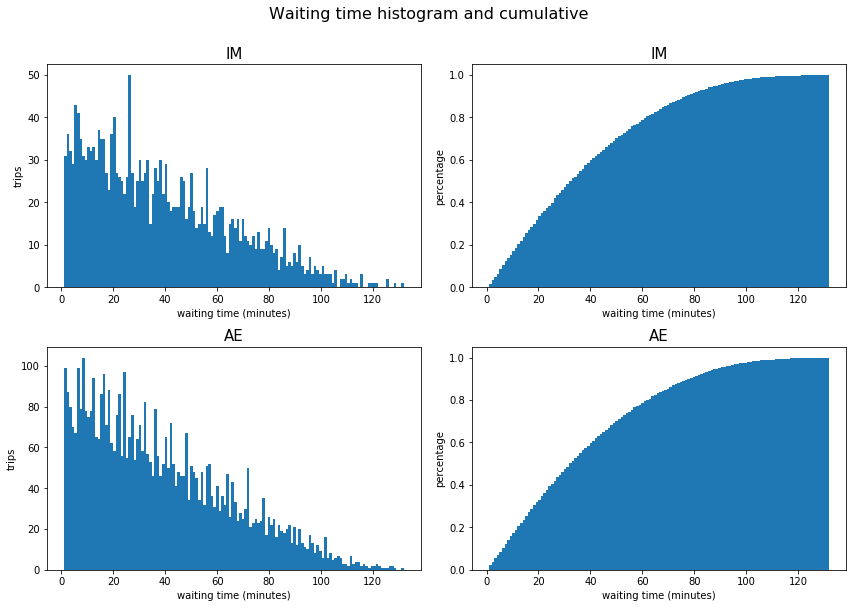

In [224]:
histogram(solutions, solutions_method,  scenario_array[4]['ps_m'])

display results (wait per point bar)

In [ ]:
bars(solutions, solutions_method, points_1200_1400_mapped)

plotting scenarios

In [ ]:
def plot_map(stop_coors,frequecies):
    
    for i in range(len(stop_coors)):
        gdf_bus_stops=gpd.read_file("files/v_uptu_paradas/v_uptu_paradas.shp")
        gdf_streets=gpd.read_file("files/v_mdg_vias/v_mdg_vias.shp")
        bus_schedules_by_stops_aux = bus_schedules_by_stops.copy()
        bus_schedules_by_stops_aux = bus_schedules_by_stops_aux.groupby(['cod_variante','cod_ubic_parada'], 
                                                                        sort=False).max().reset_index()
        #bus_schedules_by_stops_aux = pd.merge(bus_schedules_by_stops_aux, frequecies[i], 
        #                 how='right', left_on=['cod_variante'], right_on=['linea'])
       
        gdf_bus_stops = pd.merge(gdf_bus_stops, bus_schedules_by_stops_aux, 
                         how='right', left_on=['COD_UBIC_P'], right_on=['cod_ubic_parada'])
        geometry = stop_coors[i]['line_1_geometry']
        crs = {'init': 'epsg:4326'}
        syncs1 = gpd.GeoDataFrame(stop_coors, crs=crs, geometry=geometry)
        geometry = stop_coors[i]['line_2_geometry']
        crs = {'init': 'epsg:4326'}
        syncs2 = gpd.GeoDataFrame(stop_coors[i], crs=crs, geometry=geometry)
        fig, ax = plt.subplots(figsize=(15, 10))
        gdf_streets.plot(ax=ax,
                        linewidth=0.4,
                        color="black",
                        label="streets")
        gdf_bus_stops.plot(ax=ax,
                           color="blue",
                        markersize=3,
                      label="bus stops")

        syncs = syncs1.append(syncs2)

        syncs.plot(ax=ax,
                           color="red",
                        markersize=80,
                      label="sync. point")

        plt.legend()
        plt.xlabel("longitude")
        plt.ylabel("latitude")
        plt.rcParams.update({'font.size': 12})

        plt.savefig("figs/paradas_buses.png", bbox_inches='tight')

stop_coors = [
    transfers_all_day_max_tts_coors, 
    transfers_1200_1400_max_tts_coors]

frequecies = [
    frequencies_all_day, 
    frequencies_1200_1400]

plot_map(stop_coors,frequecies)


### Evolutionary ALgoritm Analysis

fitness evolution

In [ ]:
# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
fitness = pd.read_csv('fitness2',sep=';')

In [ ]:
fitness.plot()


In [ ]:
fitness[:].diff(periods=1, axis=0).plot()

In [ ]:
# Friedman test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare
# seed the random number generator
seed(1)
# generate three independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 50
data3 = 5 * randn(100) + 52
# compare samples
stat, p = friedmanchisquare(data1, data2, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')